# Lab 3: [Protein chain clustering](https://chalmers.instructure.com/courses/10918/files/918897/download?wrap=1)
* Daniel Willim: 15 h
* Erik Jergéus: 15 h

## 1 Show the distribution of phi and psi combinations using: 

### a. A scatter plot

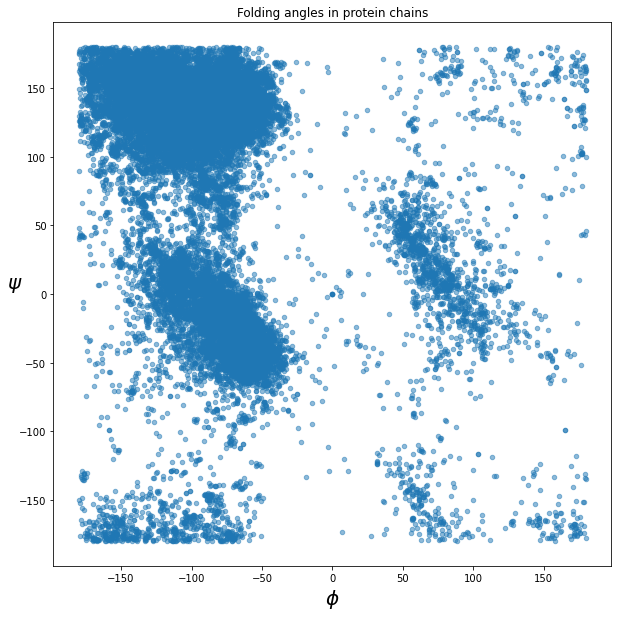

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 10]

data = pd.read_csv("data_all.csv")
data.plot.scatter(x="phi", y="psi", alpha = 0.5)
plt.title("Folding angles in protein chains")
plt.ylabel(r"$\psi$", rotation="horizontal", size=20)
plt.xlabel(r"$\phi$", size=20)
plt.show()

### b. A heatmap

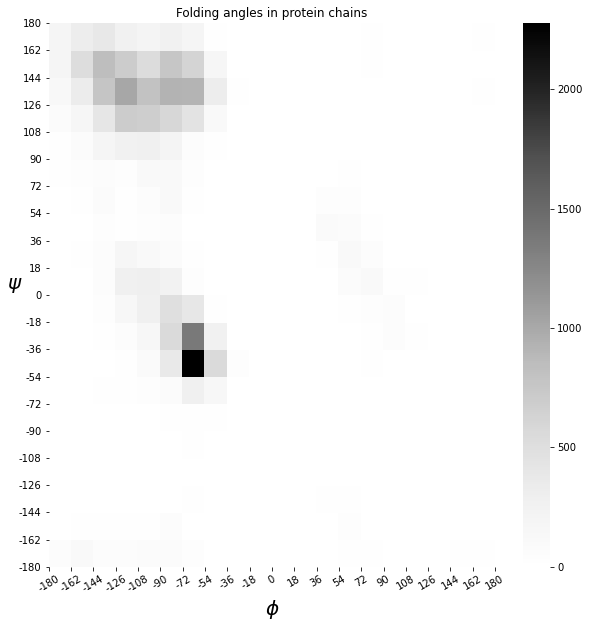

In [3]:
import numpy as np

# Set resolution of heatmap
buckets = 20

# Calulate intermiate variables
step = int(360/buckets)
breakpoints = range(-180,181,step)
breakpoints_array = [*breakpoints]
hmap = np.zeros((buckets, buckets))

# Calulate nr of points per pixel in heatmap
for i, row in data.iterrows():
    hmap[int((row.psi + 180)/step),int((row.phi + 180)/step)] += 1

# Plot heatmap    
sns.heatmap(hmap,cmap="Greys")

#Configure plot
plt.gca().invert_yaxis()
plt.xticks(range(0,buckets + 1), labels=breakpoints_array, 
           rotation=30)
plt.yticks(range(0,buckets + 1), labels=breakpoints_array, 
           rotation="horizontal")

plt.title(f"Folding angles in protein chains")
plt.ylabel(r"$\psi$", rotation="horizontal", size=20)
plt.xlabel(r"$\phi$", size=20)

plt.show()

## 2 Use  the  K-means  clustering  method to  cluster  the phi  and  psi  angle  combinations  in the data file. 

### a. Experiment with different values of K. Suggest an appropriate value of K for this task and motivate this choice. 

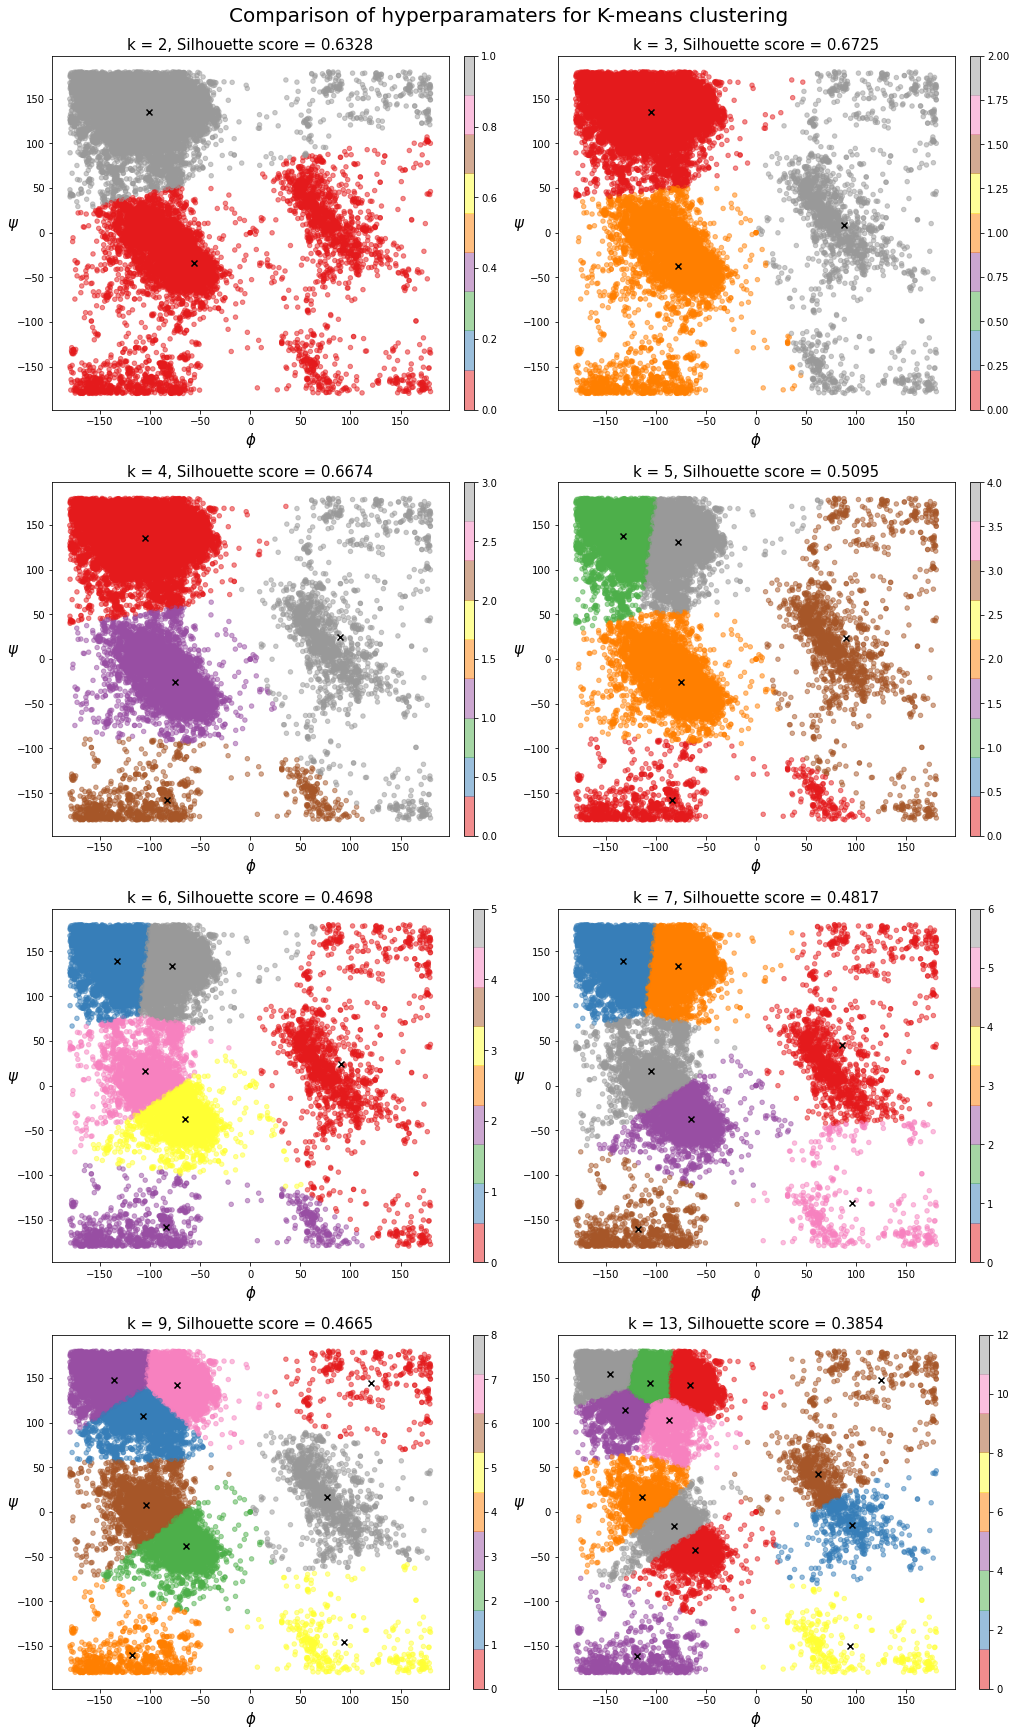

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set k values to test
ks = [2,3,4,5,6,7,9,13]

# Setup plt subfigures to hold each scatterplot
fig,axs = plt.subplots(int(len(ks)/2),2, figsize=(2*7, int(len(ks)/2)*6),
                       constrained_layout=True)
axs = axs.flatten()

# Run KMeans for each k in ks, then plot the result
for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k).fit(data[["phi", "psi"]])
    clusters = kmeans.cluster_centers_
        
    data.plot.scatter(x="phi", y="psi", alpha = 0.5, ax=axs[i], 
                      c=kmeans.labels_, cmap="Set1")
    axs[i].scatter(x=clusters[:,0], y=clusters[:,1], c="Black", marker='x')
    
    axs[i].set_title(f"k = {k}, Silhouette score = "
                     f"{silhouette_score(data[['phi', 'psi']], kmeans.labels_):,.4f}"
                    ,size=15)
    axs[i].set_ylabel(r"$\psi$", rotation="horizontal",size=15)
    axs[i].set_xlabel(r"$\phi$",size=15)

# Configure plot
fig.suptitle("Comparison of hyperparamaters for K-means clustering", size=20)
plt.show()

From the heatmap in 1b we can see that there is atleast 2 major clusters to the left and one less apparent to the right. Besides those there is a small cluster in the bottom left, which seems to be the residue from the top left cluster. That problem can be rectified by either making the clustering method cyclical around modulo 360 or transpose the data as we do in 2d.

We used the silhouette score to get an objective score on which *k* was the best. Our original hypothesis when just looking at the plots was that a *k* of 7-9 would be the best, since these seemed to group the outlying points (in the bottom left and right corner and the top right corner) into separate clusters which seemed good when only looking at the scatterplot. But as discussed in the previous paragraph most of the points were located in three distinct clusters and therefor it will be most important to cluster these into one cluster each and not split these into several clusters. This is also indicated by high Silhouette score for the runs with *k=3,4 or 5* which are the ones where the main clusters are not broken apart. 

Choosing the *k* with the best silhouette score results in *k=3*, which also seems to line-up with the clusters suggested in [the assignment link](http://bioinformatics.org/molvis/phipsi/). Therefore, we are relatively confident that a *k* of 3 is a good choice.


### b.Validate the clusters that are found with the chosen value of K. Hint: See the slides for Lecture 6, Section Validating clustering. 

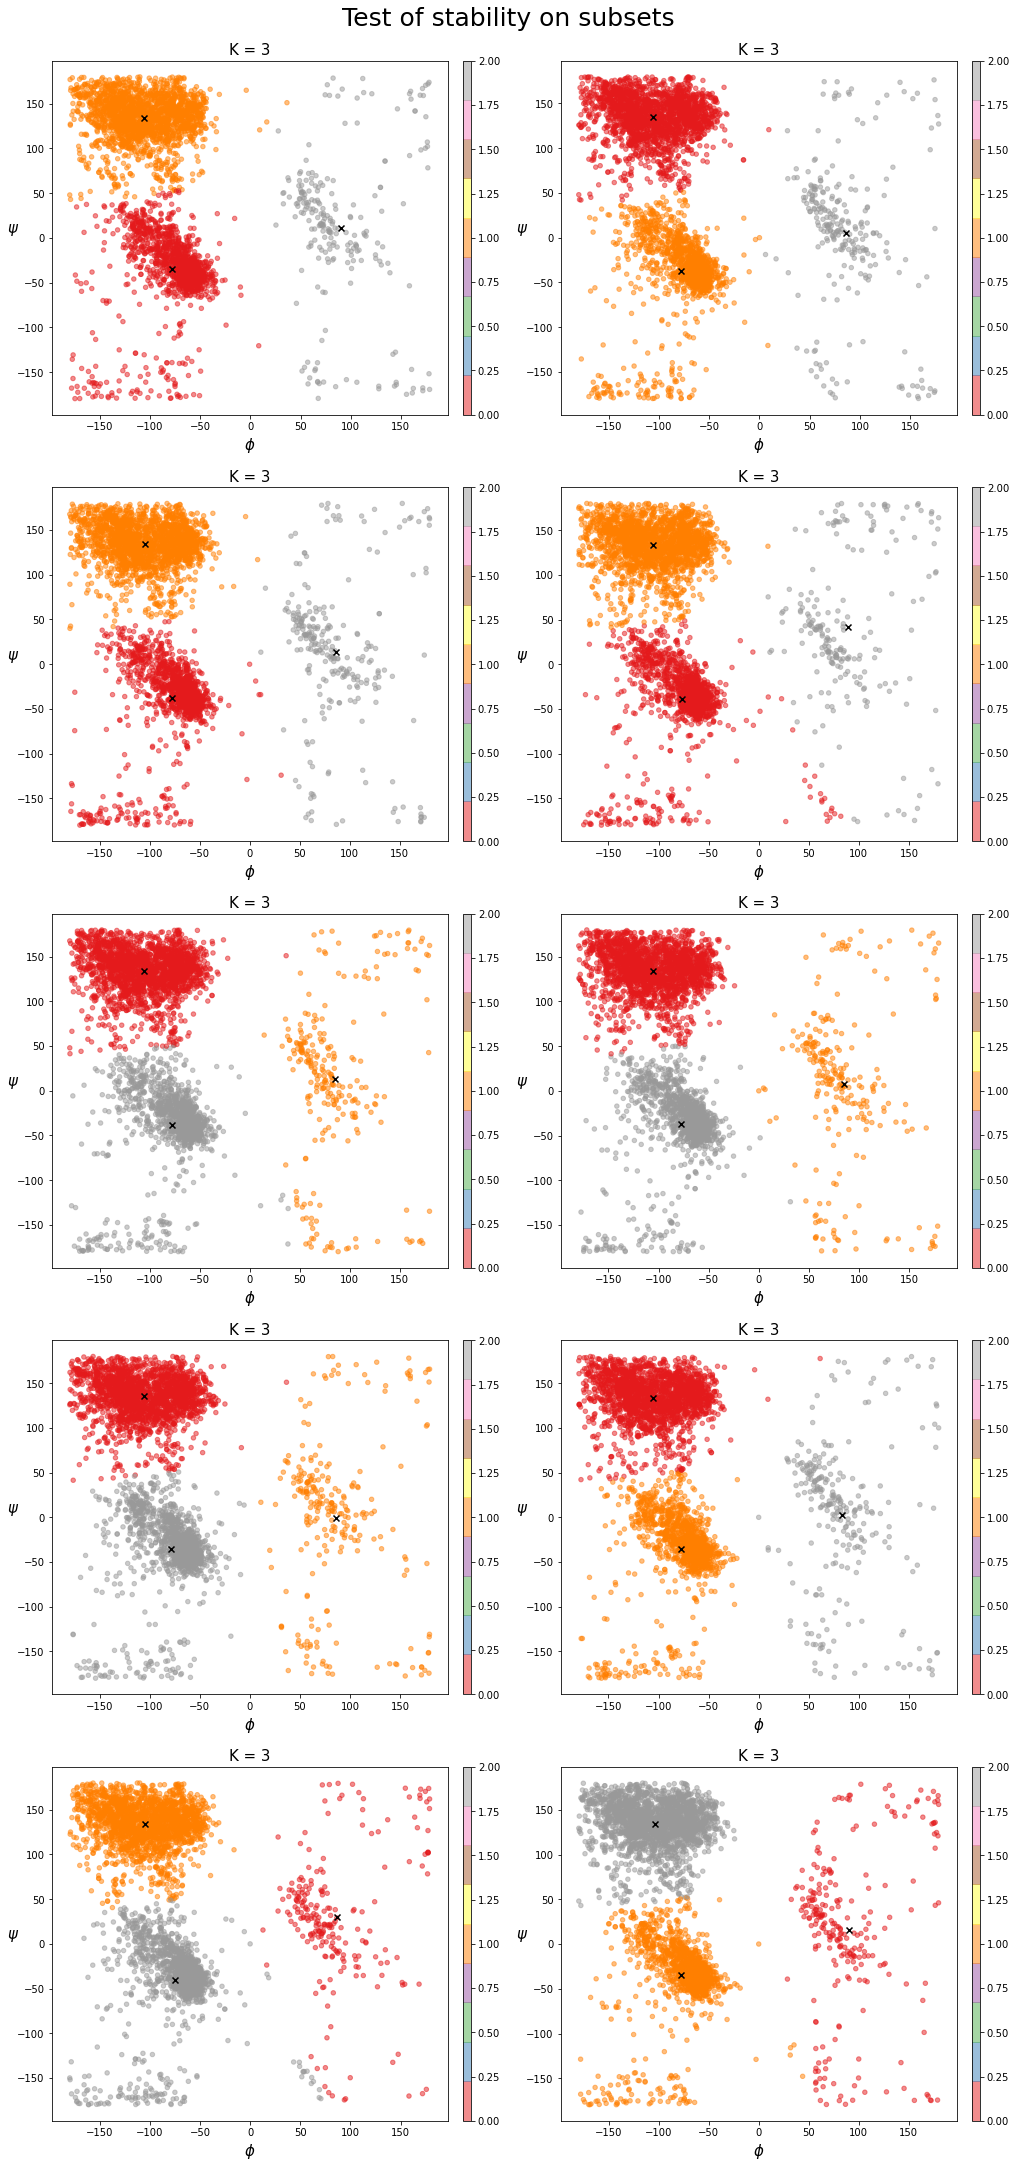

In [5]:
# Set params from test
k = 3
iterations = 10
frac = 1/8

# Create subplots for each 
fig,axs = plt.subplots(int(iterations/2),2,constrained_layout=True,
                       figsize=(2*7, int(iterations/2)*6))
axs = axs.flatten()

# Plot each test
for i in range(iterations):
    # Sample data
    sample = data.sample(frac=frac)
    sampleNumbers = sample[['phi','psi']].copy()
    
    # Run kmeans
    kmeans = KMeans(n_clusters=k).fit(sampleNumbers)
    
    # Plot result
    sample.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                        ax=axs[i], c=kmeans.labels_, cmap="Set1")
    axs[i].scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], 
                   c="Black", marker="x")
    axs[i].set_title(f"K = {k}", size=15)
    axs[i].set_ylabel(r"$\psi$", rotation="horizontal", size=15)
    axs[i].set_xlabel(r"$\phi$", size=15)

# Configure plot
fig.suptitle("Test of stability on subsets", size=25)
plt.show()

In addition to choosing the run with the highest silhouette score, we check if the clusters are stable by running K-Means on subset of the data and see if the algorithm produce the same clusters. In the above plots we ran K-Means 10 times on random samples. Each sample consisted of n/8 datapoints where n is the size of the original dataset.

From the above plots we can conclude that K-Means produce almost the same clusters each time. The only noticeable difference is that the right cluster seems to be more or less surrounded by its points, but the coordinates for the core point is still similar between subsets. Hence with *k=3* K-Means is stable on subsets. 

### c.Do the clusters found in part (a) seem reasonable? 

As discussed earlier it seems like we get reasonable clusters, since they match both the heatmap and scatterplot reasonably well and they result in a good silhouette score.

### d. Can you change the data to get better results (or the same results in a simpler way)?  (Hint:  since  both  phi  and  psi  are  periodic  attributes,  you  can  think  of shifting/translating them by some value and then use the modulo operation.) 

Since degrees are cyclical we can translate some of the points in order to minimize the amount of outliers that arise from the cluster algorithm not being able to account for modulo 360 on all angles. Some lines where the lowest amount of points appear looks to be when $\psi$ is -100 and $\phi$ is 0. Which means that all the points below those values can be added by 360 in order to make the clusters better.

The result is that all the big clusters are still the same, but there are fewer small clusters. This can be seen when *k = 4* where the bottom left cluster from before now has merged into the cluster that used to be top left. Furthermore the improvement can be seen in a higher silhouette score. (See plot below)

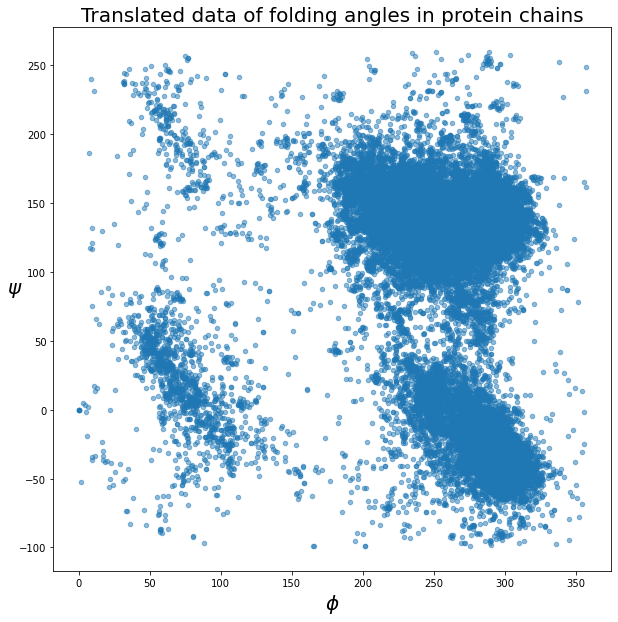

In [7]:
translated = data.copy()

# Translate psi
array = translated.psi.to_numpy()

for i,x in enumerate(array):
    if x < -100:
        array[i] = x + 360
        
translated['psi']= pd.Series(array)

# Translate phi
array = translated.phi.to_numpy()

for i,x in enumerate(array):
    if x < 0:
        array[i] = x + 360

translated['phi']= pd.Series(array)

# Plot translated data
translated.plot.scatter(x="phi", y="psi", alpha = 0.5)

# Configure plot
plt.title("Translated data of folding angles in protein chains", size=20)
plt.ylabel(r"$\psi$", rotation="horizontal", size=20)
plt.xlabel(r"$\phi$", size=20)

plt.show()

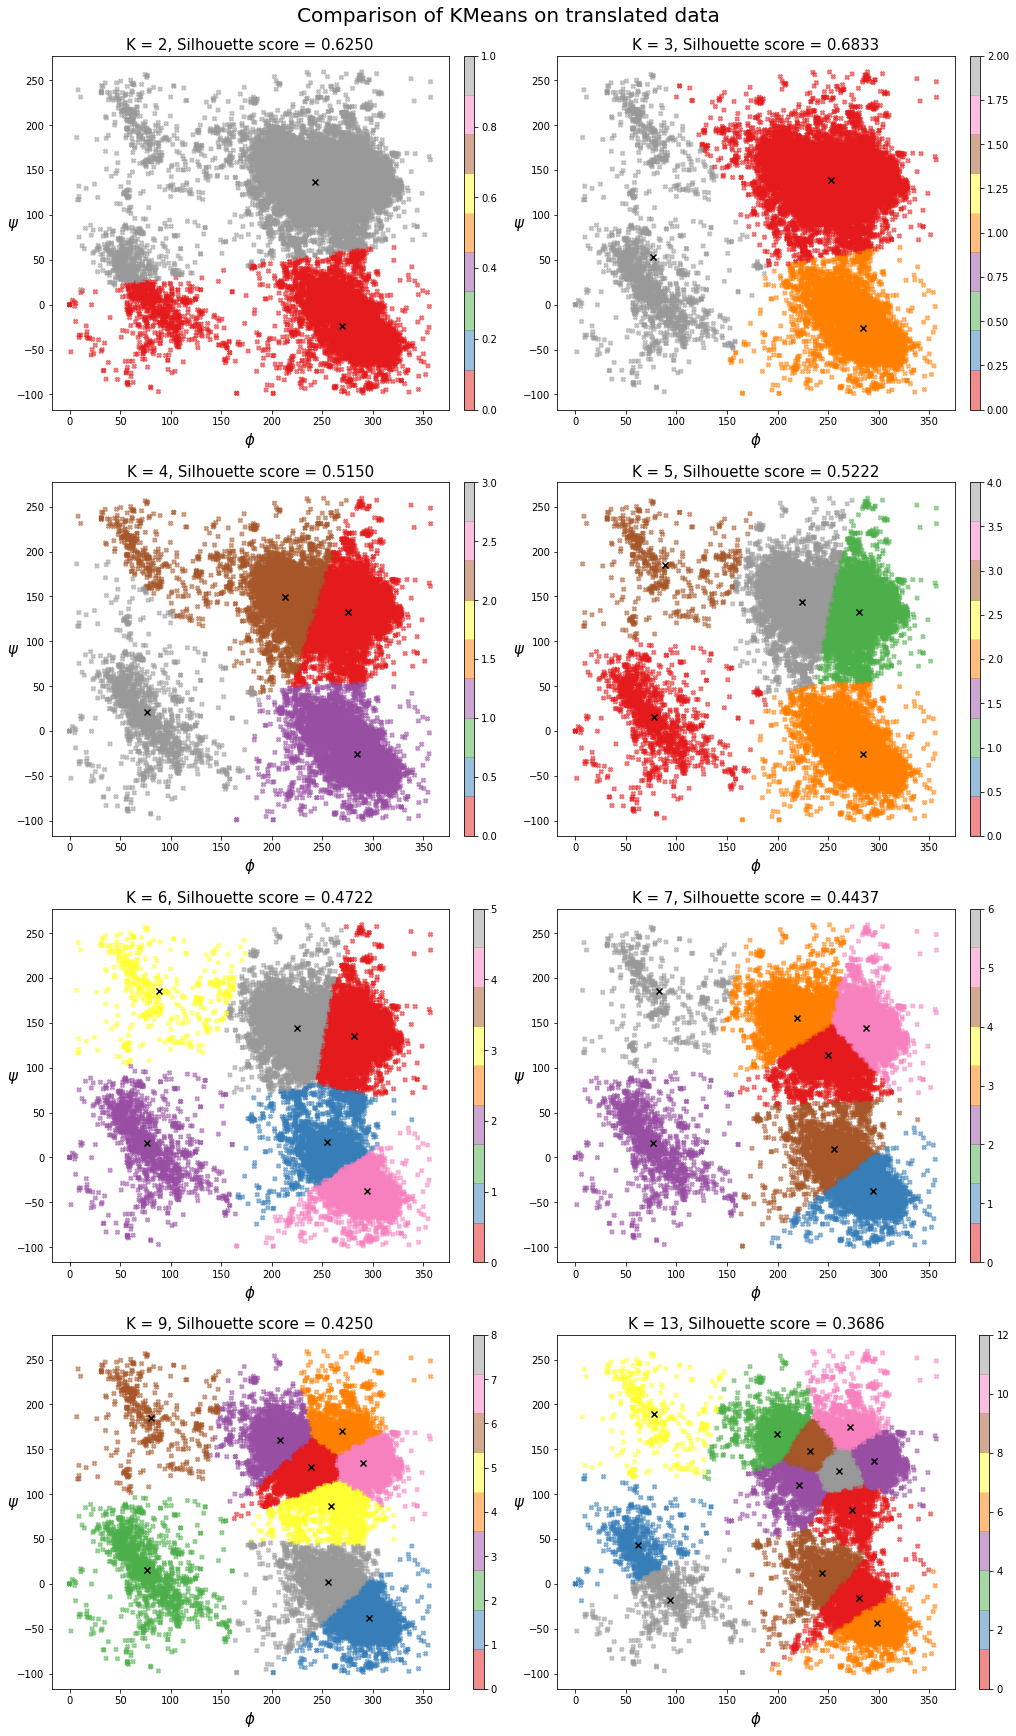

In [7]:
# KMeans to test data on
ks = [2,3,4,5,6,7,9,13]

# Setup subplots
fig,axs = plt.subplots(int(len(ks)/2),2, figsize=(2*7, int(len(ks)/2)*6),
                       constrained_layout=True)
axs = axs.flatten()

for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k).fit(translated[['phi', 'psi']])
    clusters = kmeans.cluster_centers_
    
    translated.plot.scatter(x="phi", y="psi", alpha = 0.5, ax=axs[i], 
                            c=kmeans.labels_, cmap="Set1", marker='X')
    
    axs[i].set_title(f"K = {k}, Silhouette score = "
                     f"{silhouette_score(translated[['phi', 'psi']], kmeans.labels_):,.4f}"
                     , size=15)
    axs[i].scatter(x=clusters[:,0], y=clusters[:,1], c="Black", marker="x")
    axs[i].set_ylabel(r"$\psi$", rotation="horizontal", size=15)
    axs[i].set_xlabel(r"$\phi$", size=15)

fig.suptitle("Comparison of KMeans on translated data", size=20)
plt.show()

## 3. Use the DBSCAN method to cluster the phi and psi angle combinations in the data file.

### a. Motivate: 

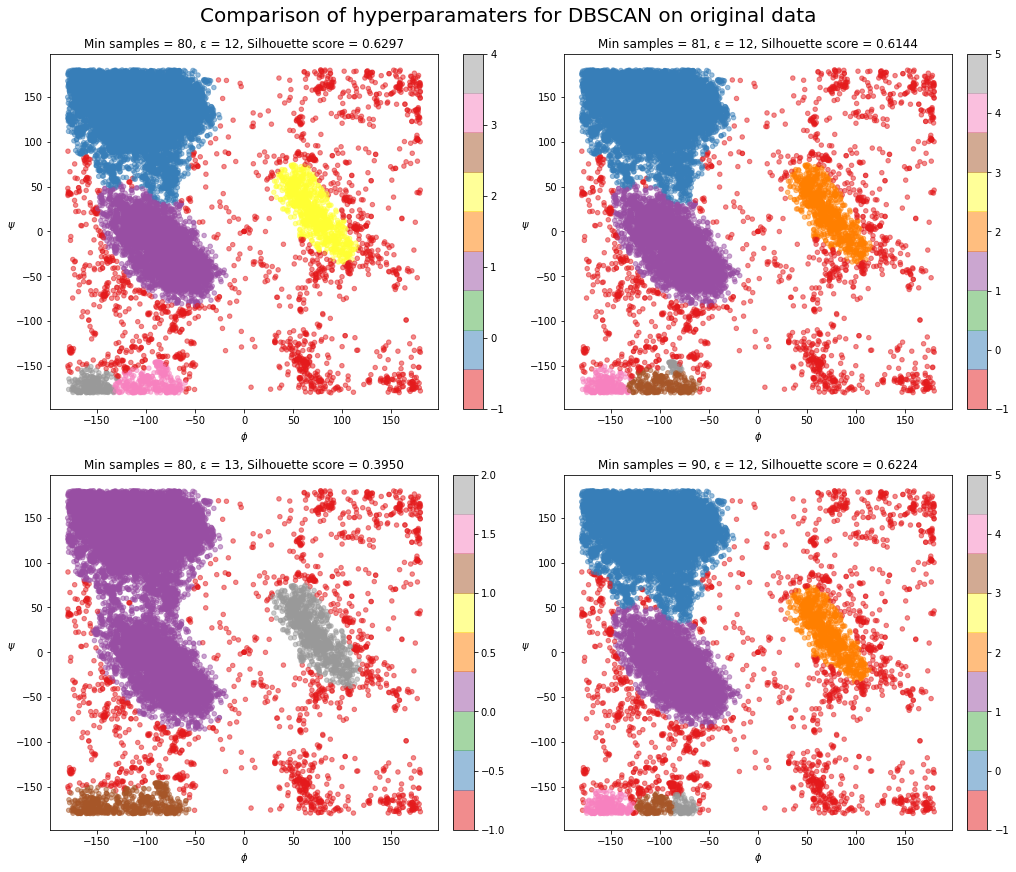

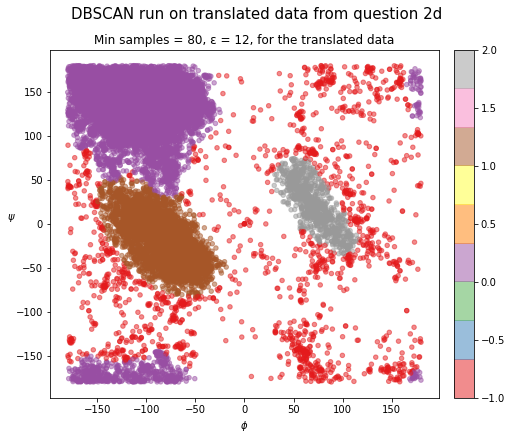

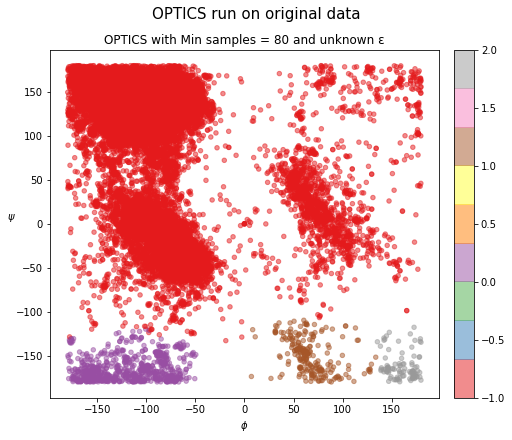

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

testParams = [(12,80),(12,81),(13,80), (12,90)]

# Configure Subplots
fig,axs = plt.subplots(int(len(testParams)/2),2,
                       figsize=(2*7, int(len(testParams)/2)*6),
                       constrained_layout=True)
axs = axs.flatten()

# Org data
for i, x in enumerate(testParams):
    dbcluster = DBSCAN(eps=x[0], min_samples=x[1]).fit(data[['phi','psi']])
    data.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                      c=dbcluster.labels_, cmap="Set1", ax=axs[i])
    axs[i].set_title(f"Min samples = {x[1]}, ε = {x[0]}, Silhouette score = "
                     f"{silhouette_score(data[['phi','psi']], dbcluster.labels_):,.4f}")
    axs[i].set_ylabel(r"$\psi$", rotation="horizontal")
    axs[i].set_xlabel(r"$\phi$")
    
fig.suptitle("Comparison of hyperparamaters for DBSCAN on original data", size=20)
plt.show()

# DBSCAN on translated data
fig,ax = plt.subplots(1,1, figsize=(1*7, 1*6),
                       constrained_layout=True)
dbcluster = DBSCAN(eps=12, min_samples=80).fit(translated[['phi','psi']])
data.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                  c=dbcluster.labels_, cmap="Set1", ax=ax)
ax.set_title(f"Min samples = {80}, ε = {12}, for the translated data")
ax.set_ylabel(r"$\psi$", rotation="horizontal")
ax.set_xlabel(r"$\phi$")
fig.suptitle("DBSCAN run on translated data from question 2d", size=15)
plt.show()

# Run OPTICS on data
fig,ax = plt.subplots(1,1, figsize=(1*7, 1*6),
                       constrained_layout=True)
opcluster = OPTICS(min_samples=80).fit(data[['phi','psi']])
data.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                  c=opcluster.labels_, cmap="Set1", ax=ax)
ax.set_title(f"OPTICS with Min samples = {80} and unknown ε")
ax.set_ylabel(r"$\psi$", rotation="horizontal")
ax.set_xlabel(r"$\phi$")
fig.suptitle("OPTICS run on original data", size=15)
plt.show()

#### i. the  choice  of the  minimum number  of  samples in  the neighbourhood for a point to be considered as a core point, and 

In most sources we found the minimum amount of points in a sample is said to be best around 2*nDimensions. In our case this does not yield any good results since there is too much noise in the data set. We chose to regard an optimum as where the silhouette score is the highest, as it is an objective metric on the clusters and we could not find any other better way to do it.

#### ii.the  choice  of the  maximum distance between two  samples  belonging to the same neighbourhood (“eps” or “epsilon”)

Most sources claim that an optimal epsilon can be found for a specific min samples by using OPTICS instead of DBSCAN. When we tried OPTICS we got a bad silhouette score and it did not seem to want to regard points as outliers, which resulted in weird clusters. For example all the three big clusters found with DBSCAN was now regarded in the same way and we instead got different clusters around the edges. Therefore we decided that it was better to simply test our way forward.

After testing values of epsilon and finding the optimum amount of samples by maximizing the silhouette score we reached epsilon = 12 and min samples = 80. Interestingly enough this point was also the one where the two big, and somewhat intersecting, clusters was precisely not clustered together. If we increased epsilon by one or decreased min samples by one they clustered together and gave a worse result. Since it is such a special set of parameters we find it reasonable that we have found optimum hyper parameters for the silhouette score metric, even if they are not particularly stable and would probably require a small tweak if the sample was even slightly changed.

NOTE: The resulting best parameters was consistent across both the original data and the translated data. The original data regarded the cut off part as another set of clusters and as such got a slightly worse silhouette score, but almost the same amount of outliers was found in both cases.

### b. Highlight  the  clusters  found  using  DBSCAN  and  any  outliers  in  a  scatter  plot. How  many  outliers  are  found?  Plot  a  bar  chart  to  show  which  amino  acid residue types are most frequently outliers

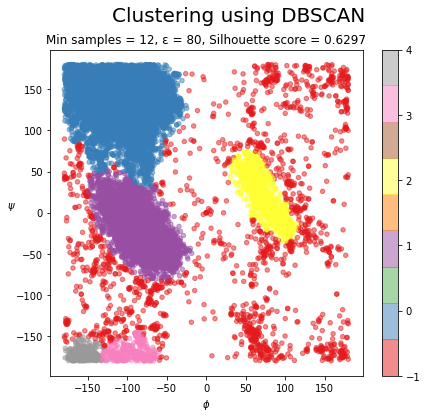

Nr of outliers in plot 1667


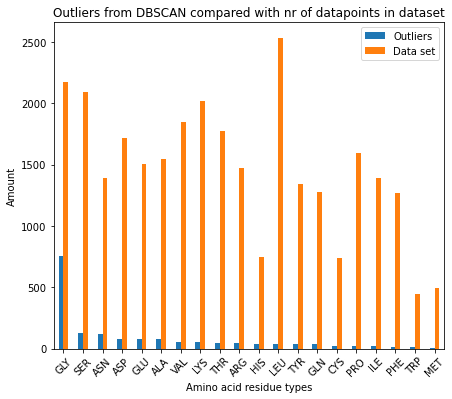

In [15]:
# Plot DBSCAN clustering on orgiginal data
fig, ax = plt.subplots(1,1, figsize=(7,6))

dbcluster = DBSCAN(eps=12, min_samples=80).fit(data[['phi','psi']])

data.plot.scatter(x="phi", y="psi", alpha = 0.5, c=dbcluster.labels_, 
                  cmap="Set1", ax=ax)
fig.suptitle("Clustering using DBSCAN", size=20)
ax.set_title(f"Min samples = {12}, ε = {80}, Silhouette score = "
             f"{silhouette_score(data[['phi','psi']], dbcluster.labels_):,.4f}")
ax.set_ylabel(r"$\psi$", rotation="horizontal")
ax.set_xlabel(r"$\phi$")
plt.show()

plt.rcParams['figure.figsize'] = [7,6]

# Filter outliers
data["label"] = dbcluster.labels_
dataOutlires = data[data.label==-1]

print(f"Nr of outliers in plot {dataOutlires.phi.count()}")

# Count 
countRes = dataOutlires["residue name"].value_counts().to_frame()
org = data["residue name"].value_counts().to_frame()

# Merge dataframes
countRes = countRes.merge(org, left_index=True, right_index=True)
countRes.columns = ["Outliers", "Data set"]

# Plot data
countRes.plot.bar()
plt.xticks(rotation=45)
plt.xlabel("Amino acid residue types")
plt.ylabel("Amount")
plt.title("Outliers from DBSCAN compared with nr of datapoints in dataset")
plt.show()

plt.rcParams['figure.figsize'] = [10,10]

Above we plotted the clusters produced by running DBSCAN with the hyperparameters from question 3a. In this plot there are 1667 outliers, indicated by red data points in plot. From the bar graph we see that amino acids of residue type GLY are overrepresented among the outliers, this will be further discussed in 4b.

### c. Compare the clusters found by DBSCAN with those found using K-means

The main difference between the methods is that DBSCAN has smaller clusters, since it regards some points as outliers. Then we also see that K-means is more inclined to include small clusters which are considered a cluster of outliers in the DBSCAN (see top left). Furthermore we can see on the intersection between the two right-most clusters that K-means has a straight line, but the DBSCAN method find a less linear intersection. This adds upp with the lecture-slide's remark about DBSCAN being able to find non-linear relationships in clusters.

In general the methods resulted in similar main clusters, which might have been a cause of us using the same metric for deciding the hyperparameters, silhouette score.

*Below the result from K-Means and DBSCAN are plotted side-to-side*

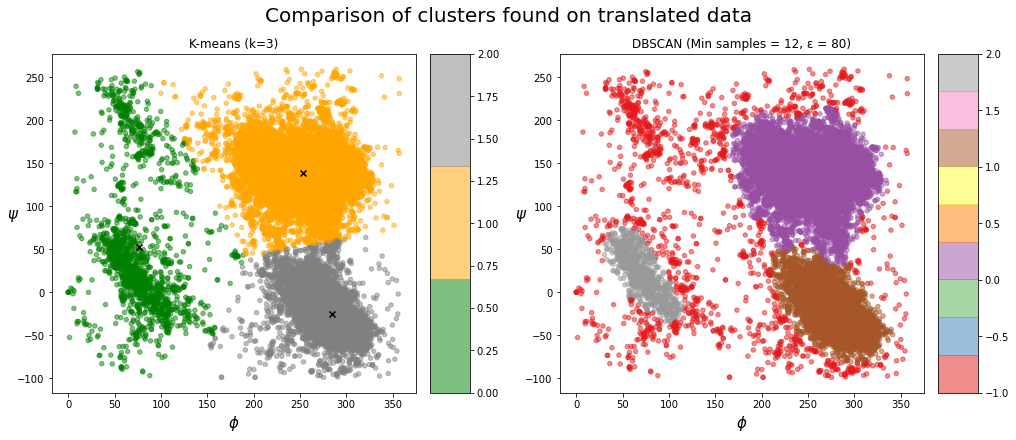

In [18]:
from matplotlib import colors

fig,axs = plt.subplots(1,2,figsize=(2*7, 1*6), constrained_layout=True)

# Cluster data
kmeans = KMeans(n_clusters=3).fit(translated[['phi', 'psi']])
clusters = kmeans.cluster_centers_

dbcluster = DBSCAN(eps=12, min_samples=80).fit(translated[['phi','psi']])

# Plot data
translated.plot.scatter(x="phi", y="psi", alpha = 0.5, ax=axs[0], c=kmeans.labels_, 
                        cmap=colors.ListedColormap(['green','orange','grey']))
axs[0].scatter(x=clusters[:,0], y=clusters[:,1], c="Black", marker="x")

translated.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                        c=dbcluster.labels_, cmap="Set1", ax=axs[1])

# Configure plots
axs[0].set_title(f"K-means (k=3)")
axs[0].set_ylabel(r"$\psi$", rotation="horizontal", size=15)
axs[0].set_xlabel(r"$\phi$", size=15)

axs[1].set_title(f"DBSCAN (Min samples = {12}, ε = {80})")
axs[1].set_ylabel(r"$\psi$", rotation="horizontal", size=15)
axs[1].set_xlabel(r"$\phi$", size=15)

fig.suptitle("Comparison of clusters found on translated data", size=20)

plt.show()

### d. Discuss whether the clusters found using DBSCAN are robust to small changes in  the  minimum  number  of  samples  in  the  neighbourhood  for  a  point  to  be considered  as  a  core  point,  and/or  the  choice  of  the  maximum  distance between   two   samples   belonging   to   the   same   neighbourhood   (“eps”   or “epsilon”)

As mentioned in 3a and showed in 3b the DBSCAN methods can be very volatile to small changes. Simply increasing the epsilon from 12 to 13 combines the two largest clusters and greatly impacts the silhouette score and likewise decreasing the minimum amount of samples by 1 has the same affect. However both parameters seem quite stable in the other direction, increasing the min samples just includes slightly fewer points, but does not move the core clusters without large changes. Likewise decreasing epsilon by a reasonale amount doesn't impact the clusters hugely. Therefore it can be reasonable to slightly overestimate the min samples and underestimate the epsilon if it's important to get stable hyperparameters (for example when checking stability on subsets as we did in 2b).

## 4. The data file can be stratified by amino acid residue type.  

### a. Use  DBSCAN to cluster the data that have residue type  PRO. Investigate how the clusters found for amino acid residues of type PRO differ from the general clusters (i.e., the clusters that you get from DBSCAN with mixed residue types in question 3).

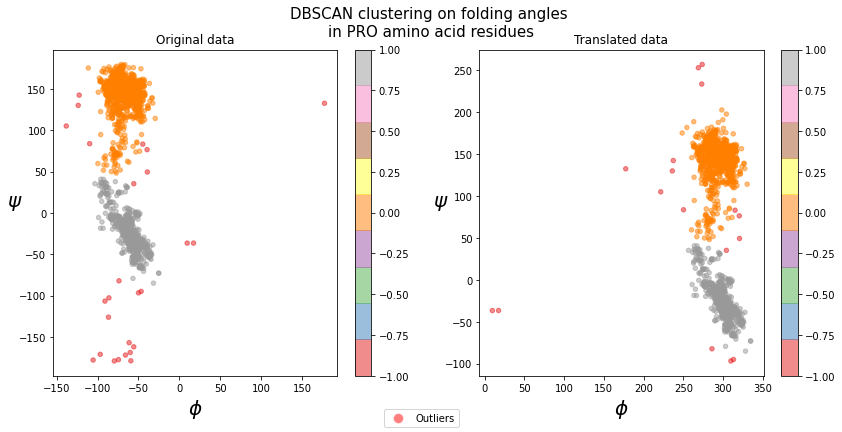

In [11]:
from matplotlib.lines import Line2D 

# Prepare subplots
plt.rcParams['figure.figsize'] = [14,6]
fig, axs = plt.subplots(1,2)

# Filter data and run dbscan on translated data
proTransData = translated[translated["residue name"] == "PRO"]
dbcluster2 = DBSCAN(eps=20, min_samples=40).fit(proTransData[['phi','psi']])

proTransData.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                          c=dbcluster2.labels_, cmap="Set1", ax=axs[1])

# Configure plot   
axs[1].set_title("Translated data")
axs[1].set_ylabel(r"$\psi$", rotation="horizontal", size=20)
axs[1].set_xlabel(r"$\phi$", size=20)

# Filter data and run dbscan on original data
proData = data[data["residue name"] == "PRO"]
dbcluster3 = DBSCAN(eps=20, min_samples=40).fit(proData[['phi','psi']])

proData.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                     c=dbcluster3.labels_, cmap="Set1", ax=axs[0])

# Configure plot    
axs[0].set_title("Original data")
axs[0].set_ylabel(r"$\psi$", rotation="horizontal", size=20)
axs[0].set_xlabel(r"$\phi$", size=20)

# Configure figure
fig.legend(loc="lower center", handles=
           [Line2D([0], [0], marker='o', color='w', label='Outliers', 
                   markerfacecolor='red', markersize=10, alpha=0.5)])
fig.suptitle("DBSCAN clustering on folding angles \nin PRO amino acid residues", 
             size=15)
plt.show()

Above we've plotted the clustes found by DBSCAN on both the translated data from question 2d and on the orginial data for amino acids with residue type PRO. In both cases we find the same two clusters with very few outliers and can conclude that this clustering was not affected by the translation of the data.

In the plots we also see that the clusters match two of the bright areas in the heatmap and two of the main clusters found in question 2 and 3. Hence amino acids with type PRO have similar folding angles as the majority of the overall data. This is also backed up by the bar graph in question 2b where there are almost no amino acids with residues of type PRO among the outlires.

### b. Now use DBSCAN to cluster the data that have residue type GLY. Investigate how the clusters found for amino acid residues of type GLY differ from the general clusters. 


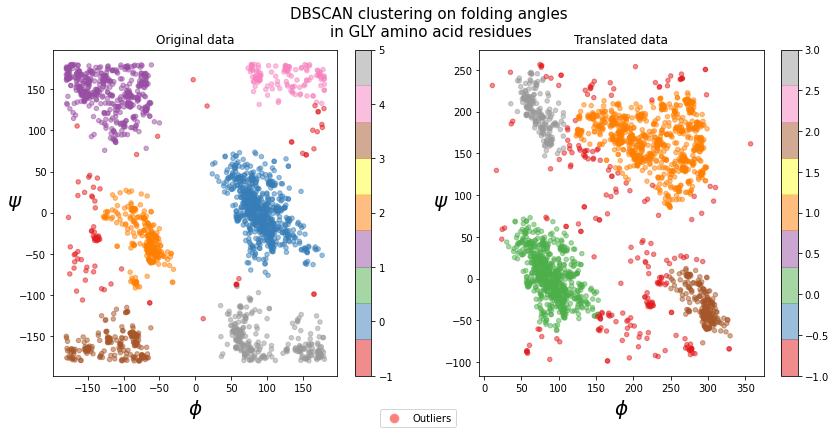

In [12]:
# Prepare subplots
plt.rcParams['figure.figsize'] = [14,6]
fig, axs = plt.subplots(1,2)

# Filter data and run dbscan on translated data
glyTransData = translated[translated["residue name"] == "GLY"]
dbcluster4 = DBSCAN(eps=17, min_samples=30).fit(glyTransData[['phi','psi']])

glyTransData.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                          c=dbcluster4.labels_, cmap="Set1", ax=axs[1])

# Configure plot   
axs[1].set_title("Translated data")
axs[1].set_ylabel(r"$\psi$", rotation="horizontal", size=20)
axs[1].set_xlabel(r"$\phi$", size=20)

# Filter data and run dbscan on original data
glyData = data[data["residue name"] == "GLY"]
dbcluster5 = DBSCAN(eps=25, min_samples=30).fit(glyData[['phi','psi']])

glyData.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                     c=dbcluster5.labels_, cmap="Set1", ax=axs[0])

# Configure plot    
axs[0].set_title("Original data")
axs[0].set_ylabel(r"$\psi$", rotation="horizontal", size=20)
axs[0].set_xlabel(r"$\phi$", size=20)

# Configure figure
fig.legend(loc="lower center", handles=
           [Line2D([0], [0], marker='o', color='w', label='Outliers', 
                   markerfacecolor='red', markersize=10, alpha=0.5)])
fig.suptitle("DBSCAN clustering on folding angles \nin GLY amino acid residues", 
             size=15)
plt.show()

Above we've plotted the clusters found by DBSCAN on both the translated data from question 2d and on the original data for amino acids of residue type GLY. In the left plot DBSCAN found 6 different clusters where several of the clusters are cut in half by the border of the plot. As discussed in 2d this is due to the cyclical nature of angles. We see that in the right scatterplot where we have translated the data to mitigate this problem DBSCAN finds 4 clusters and non of these end right at the border of a plot. Hence translating the data helped to create better clusters. 

Compared to amino acids of type PRO, GLY amino acids are more spread out over the whole plot and the clusters found by DBSCAN do not always correlate with the clusters found in question 3c. For example, the grey cluster in the right plot are all classified as outliers in question 3c. This is also supported by the bar graph in 3b where GLY amino acid are highly overrepresented among the outliers.